In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import operator
from statistics import pstdev
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import sys
sys.path.insert(0, "../code")
from get_result import show_result
from WAC import WAC
from WAC_ATT import WAC_ATT
from WAC_ATT_2 import WAC_ATT_2
from WAC_SATT import WAC_SATT
from WAC_MATT import WAC_MATT
from WAC_MATT_T import WAC_MATT_T
from data_pre import data_preprocessing
import pickle
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(1)

In [2]:
(voc_ix, train_data,test_data, dev_data) = data_preprocessing()
ix_voc = {}
for k,i in voc_ix.items():
    ix_voc[i] = k

runtime: 1.484684944152832


# Word Averaging Binary Classifier 

## Implementation
* Implemented in `WAC.py` and `wac_eval.py`

* I use batch size of 500

* Use Adagrad, with `lr = 1e-02`

* Use embedding dimension of 100

* Use sparse wordembedding with dimension 100; initialized uniformly between -0.l and 0.1 (did find significant improvement compared with when weights initialized between -1 and 1)

## Analysis

In [3]:
name = 'wac.pt'
model1 = show_result(name, train_data, dev_data,test_data,sample = False)

show result for wac.pt
performance of best model:
model acc on train data: 0.9455968165822803
model acc on dev data: 0.8211009174311926
model acc on test data: 0.8110928061504667


### Compare L2 norm of word embedding

In [4]:
word_norm = (model1.word_embeddings.weight.data**2).sum(dim = 1).numpy()
word_norm = np.sqrt(word_norm)

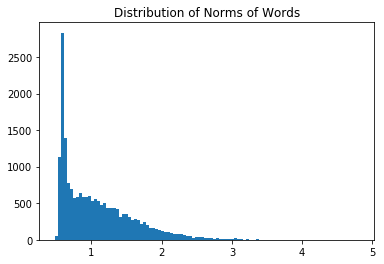

In [5]:
plt.hist(word_norm,bins = 100)
plt.title("Distribution of Norms of Words")
plt.show()

In [6]:
word_norm_ix = word_norm.argsort()

In [7]:
n_top = 15
print("words with least norm\n")
print("word \t: norm\n")
for ix in word_norm_ix[0:n_top]:
    print("{}\t: {}\n".format(ix_voc[ix], word_norm[ix]))

words with least norm

word 	: norm

Carrera	: 0.47581183910369873

deathbed	: 0.4863074719905853

waltzes	: 0.48984774947166443

bio	: 0.4902549684047699

Strap	: 0.4966864585876465

Pabst	: 0.4998193383216858

driving	: 0.5006687045097351

Ferzan	: 0.5024561882019043

hedonist	: 0.5024824738502502

sea	: 0.5034908056259155

locales	: 0.5041689872741699

marvels	: 0.5061100721359253

Shakesperean	: 0.5062376260757446

gargantuan	: 0.5063695907592773

unlike	: 0.5065687894821167



In [8]:
n_top = 15
print("words with greatest norm\n")
print("word \t: norm\n")
for ix in reversed(word_norm_ix[-n_top:-1]):
    print("{}\t: {}\n".format(ix_voc[ix], word_norm[ix]))

words with greatest norm

word 	: norm

remarkable	: 4.497736930847168

lacking	: 4.360334396362305

mess	: 4.239830017089844

wonderful	: 4.0834059715271

powerful	: 4.034727096557617

suffers	: 4.002315998077393

devoid	: 4.000951766967773

waste	: 3.982226848602295

hilarious	: 3.9694108963012695

lacks	: 3.8930931091308594

captures	: 3.7990055084228516

flat	: 3.7967562675476074

terrific	: 3.767505407333374

pointless	: 3.6902318000793457



## Comment:

* The words with the least norm are those that 
    * do not have obvious sentiments
    * probably rare, even never appear in training

* The words with greatest norm are those that:
    * have rather clear sentiments
    * probably quite frequently appear in training
    
* If we also take a look at the overall distribution of norms for words, we can see most words haev small weight, thus are not very important for making decision; very few words have big norms as words listed above. Therefore, those strong words are probably strong signal for sentiment analysis. 

#  Attention-Weighted Word Averaging 

## Implementation
* Implemented in `WAC_ATT.py` and `wac_att_eval.py`

* I use batch size of 500

* Use Adagrad, with `lr = 1e-02`

* Use embedding dimension of 100

* Use wordembedding with dimension 100; initialized uniformly between -0.l and 0.1 

## Analysis:  Word Embeddings and the Attention Vector

In [9]:
name = 'wac_att.pt'
model2 = show_result(name, train_data, dev_data,test_data,sample = False)

show result for wac_att.pt
performance of best model:
model acc on train data: 0.9342974654412092
model acc on dev data: 0.8245412844036697
model acc on test data: 0.814387699066447


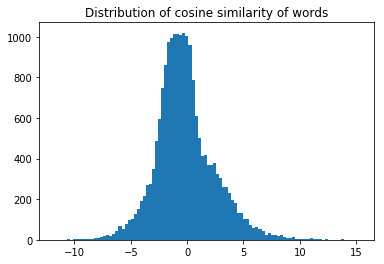

In [10]:
cos_sim = torch.matmul(model2.u.data, model2.word_embeddings.weight.data.t())
#cos_sim = cos_sim.numpy()[0,:]
plt.hist(cos_sim.numpy(), bins = 100)
plt.title("Distribution of cosine similarity of words")
plt.show()

In [11]:
cos_sim_ix = cos_sim.argsort()

In [12]:
n_top = 15
print("words with greatest cosine similarity\n")
print("word \t: cosine similarity\n")
for ix in reversed(cos_sim_ix[-n_top:-1]):
    ix = ix.item()
    print("{}\t: {}\n".format(ix_voc[ix], cos_sim[ix]))


words with greatest cosine similarity

word 	: cosine similarity

mess	: 13.902626037597656

bad	: 13.772995948791504

devoid	: 13.637480735778809

waste	: 13.105344772338867

worse	: 12.94054126739502

flat	: 12.800941467285156

lacking	: 12.536871910095215

lacks	: 12.505407333374023

lack	: 12.405756950378418

none	: 12.111207962036133

suffers	: 11.976886749267578

poorly	: 11.917226791381836

pointless	: 11.910005569458008

neither	: 11.699939727783203



In [13]:
n_top = 15
print("words with smallest cosine similarity\n")
print("word \t: cosine similarity\n")
for ix in cos_sim_ix[0:n_top:]:
    ix = ix.item()
    print("{}\t: {}\n".format(ix_voc[ix], cos_sim[ix]))


words with smallest cosine similarity

word 	: cosine similarity

and	: -11.76754379272461

with	: -11.178474426269531

you	: -10.505175590515137

film	: -10.488924980163574

an	: -10.26484489440918

comedy	: -10.084554672241211

one	: -9.961816787719727

a	: -9.891201972961426

has	: -9.838922500610352

makes	: -9.613327026367188

work	: -9.58224868774414

story	: -9.498851776123047

,	: -9.405157089233398

will	: -9.348079681396484

art	: -9.159615516662598



### Comment:
My finding:
* Words that frequently appear but not indicative of sentiments have low cosine similarity, and thus low attention 

* Words that have obvious, and mostly negative sentiment signal, and less frequent,  has high cosine similarity, and thus higher attention.  

Hypothesis:
* For the frequent words that don't have clear emotional meanings (appear often in both positive and negative sentences), the model learns to ignore them with small attention. 

* For the words that appear less often but ofen appear in negative (positive sentence), the model learns to pay more attention to it. 

* As to why the words that attract most attention are almost all negative, maybe it is related to how people express their feelings: positive word appears more often; a sentence can have some positive word but a single strong negative word  will decide the final sentiment. 

## Analysis: Variance of Attentions

In [14]:
## find freq word (top 100 in training)
voc_count = {}
for ix in ix_voc.keys():
    voc_count[ix] = 0
#voc_count[0] = 0
for sent in train_data.tensors[0]:
    for w in sent.numpy():
        if w != 0:
            voc_count[w] += 1
sorted_voc = sorted(voc_count.items(), key = operator.itemgetter(1))
freq_word = [pair[0] for pair in reversed(sorted_voc[-100:-1])]

## compute att weights for each frequent word
freq_wordset = set(freq_word)

In [15]:
## copy that dict to a new dict to store (std/mean)
X,_,lens = train_data.tensors
batch_size, maxlen = X.size()
embeds = model2.word_embeddings(X)
## build a mask for paddings
mask = torch.arange(maxlen)[None,:].float() < lens[:,None].float()
#print(mask.size())

## compute attention
u = torch.unsqueeze(model2.u,0)
u = torch.unsqueeze(u,0)
#sim = torch.exp(self.cosine(self.u.weight.data.view(1,1,-1), embeds))
sim = model2.cosine(u, embeds)
sim = torch.mul(sim.exp(), mask.float())

att = sim/ sim.sum(dim = 1, keepdim=True)

In [16]:
att_freqword = {}
for w in freq_word:
    att_freqword[w] = []
    
for sent, a,l in zip(X,att, lens):
    for w, wa in zip(sent[:l],a[:l]):
        if w.item() in freq_wordset:
            att_freqword[w.item()].append(wa.item())
            
att_ratio = {}
for w in freq_word:
    att_ratio[w] = pstdev(att_freqword[w])/np.mean(att_freqword[w])

att_ratio_sort = sorted(att_ratio.items(), key = operator.itemgetter(1))
att_ratio_sort = att_ratio_sort[::-1]
n_top = 30
for (ix,_) in att_ratio_sort[:n_top]:
    print(ix_voc[ix])


-RRB-
us
-LRB-
`
comedy
up
enough
so
characters
more
out
life
way
much
''
his
'
are
film
something
movies
movie
The
can
...
its
story
most
work
and


### Comment:
Those words are not clear indicative of emotions themselves. However, their roles in the sentences vary. For example, think about word `film`: sentences `This film ...` can be both positive and negative, and thus `film` in these sentences get small attention' however, `great film` probably only appears in positive review. The model learns (through correlation, since what matters is `good`) that on those occasions, `film` correlates with positive, thus giving it more attention.  

# Self-attention


## Implementation
* Implemented in `WAC_SATT.py` and `WAC_SATTR` respectively. 

* I use batch size of 500

* Use Adagrad, with `lr = 1e-02`

* Use embedding dimension of 100

* Use wordembedding with dimension 100; initialized uniformly between -0.l and 0.1

In [17]:
name = 'wac_satt.pt'
model3 = show_result(name, train_data, dev_data,test_data,sample = False)

show result for wac_satt.pt
performance of best model:
model acc on train data: 0.9061901438774147
model acc on dev data: 0.8130733944954128
model acc on test data: 0.7984623833058759


In [18]:
name = 'wac_sattr.pt'
model4 = show_result(name, train_data, dev_data,test_data,sample = False)

show result for wac_sattr.pt
performance of best model:
model acc on train data: 0.9190336901809975
model acc on dev data: 0.8142201834862385
model acc on test data: 0.8072487644151565


## Comment
The self-attention models are not very stable in training. Residual connection makes it better, but still it is fragile in training with accuracy dropping rapidly after a few epochs.

# Enriching the Attention Function

From the previous 3 models, I find that the best model is model 2 (the model that computes attention by cosine similarity with a vector $u$). So I build on its architecture.  All the other hyperparameters remain the same as previous ones. 

I begin by separating the key, query and value (call the model `wac_att_2`, implemented in `WAC_ATT_2.py`). Seeing it performs well, I  add another head to it (call it model `wac_matt`, implemented in `WAC_MATT.py`). 

Then I think $u$ is a global variable for all sentences. This means the absolute attention (similarity score) is fixed for each word, no matter in what context. Maybe we need to let it be senetence-specific. 

Thus I use LSTM to get a "thought vector" (the last hidden vector) which I think should contain context information. Then the final $u$ is the convex combination between this thought vector and original $u$. However, it is very slow to train and the result is not as good as simpler model. (This model is called `wac_attt`, with the last `t` meaning thought vector; implemented in `WAC_ATT_T.py`)

I continue with this idea, and use the "thought vector" to compute attention for the second head. Again, it is very slow to train and the result is not as good as simpler model.  (This model is called `wac_mattt`, with the last `t` meaning thought vector; implemented in `WAC_MATT_T.py`)

In [19]:
name = 'wac_att_2.pt'
_ = show_result(name, train_data, dev_data,test_data,sample = True)

show result for wac_att_2.pt
performance of best model:
model acc on train data: 0.937
model acc on dev data: 0.8211009174311926
model acc on test data: 0.8220757825370676


In [20]:
name = 'wac_matt.pt'
_ = show_result(name, train_data, dev_data,test_data,sample = True)

show result for wac_matt.pt
performance of best model:
model acc on train data: 0.936
model acc on dev data: 0.8222477064220184
model acc on test data: 0.8209774848984075


In [21]:
name = 'wac_attt.pt'
_ = show_result(name, train_data, dev_data,test_data,sample = True)

show result for wac_attt.pt
performance of best model:
model acc on train data: 0.932
model acc on dev data: 0.8176605504587156
model acc on test data: 0.8105436573311368


In [22]:
name = 'wac_mattt.pt'
_ = show_result(name, train_data, dev_data,test_data,sample = True)

show result for wac_mattt.pt
performance of best model:
model acc on train data: 0.934
model acc on dev data: 0.8130733944954128
model acc on test data: 0.8077979132344866


## Conclusion:

### Result:
The best model (in test dataset) so far is `wac_att_2`, which is just separating the key, value of the model in problem 2. 

With multihead (two head), it does better in development data, but slightly worse in test dataset. 

Although those that use "thought vector" are more complex and should learn better in theory, they do not do that well. Maybe I can tune parameter (for example parameter `lam` that controls the convex combination), but the model takes too long to train (120 seconds per epoch, whereas other LSTM-free model takes less than 10 seconds to train). 

### Discussion:
From the accuracy on train, test, dev set, we can see the model overfits. Therefore, we might be able to do better on those complicated models if we add more penalty, or use sparse embedding (for some reason I cannot use sparse embedding for those models). Thus we cannot reach a conclusion about the best architecture on this task yet. 